# Basic hydroelastic contact
For instructions on how to run these tutorial notebooks, please see the [index](./index.ipynb).

If you are not familiar with Drake, see the [index](./index.ipynb) or study [authoring_multibody_simulation.ipynb](./authoring_multibody_simulation.ipynb).  <!--by Zach Feng--> 

# Introduction

This tutorial shows you how to set up dynamic simulations with hydroelastic contacts.
It also shows you how to report contact results numerically
and visualize them in MeshCat.  For context, we use a simple example of a compliant block dropped onto a rigid horizontal rectangular plate.  Contact forces are calculated and visualized.

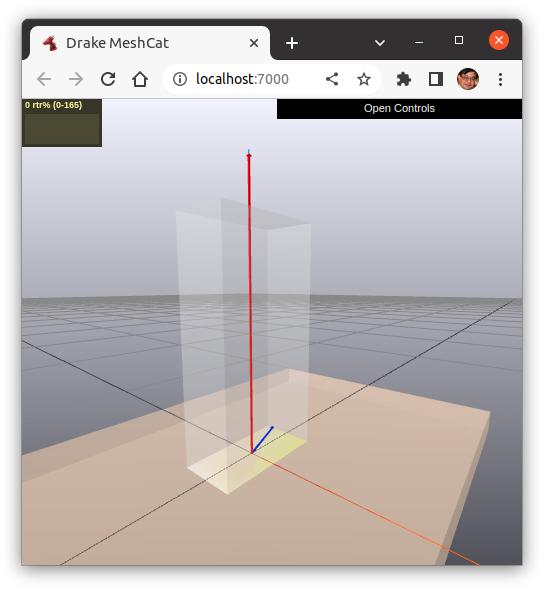

Drake's *Hydroelastic Contact Model* evolved at Toyota Research Institute in conjunction with work by Ryan Elandt who invented the [*Pressure Field Contact (PFC)*](https://ecommons.cornell.edu/handle/1813/112919) model.  Ryan's PhD thesis describes the usefulness of the PFC model:

> "*...This model is useful in situations where deformation in the contact region is qualitatively important, but need not be accurate. PFC is a model of, and not a convergent approximation of, continuum mechanics. In PFC, each of the two contacting objects is assigned an immutable internal virtual pressure field. ... the PFC contact surface is defined as the set of points where the two pressure fields are equal. ...*"

For an excellent overwiew of hydroelastic contact,
read these two articles (less than 10 minutes each):

- [Rethinking Contact Simulation for Robot Manipulation](https://medium.com/toyotaresearch/rethinking-contact-simulation-for-robot-manipulation-434a56b5ec88)
- [Drake: Model-based design in the age of robotics and machine learning.](https://medium.com/toyotaresearch/drake-model-based-design-in-the-age-of-robotics-and-machine-learning-59938c985515)

Hydroelastic contact is faster than Finite Element analysis, but less accurate.
Although hydroelastic contact can be slower than point contact models 
(used in some simulators -- including an optional one in Drake),
hydroelastic contact has more stable behavior in realistic situations involving
friction, rolling, energy dissipation, and non-convex geometries.

When two rigid bodies are interacting due to hydroelastic contact, neither has actual mechanical deformation, i.e., the bodys' mass, center of mass, and inertia properties are unaffected by hydroelastic contact. However, their force interaction is calculated as if there was deformation.

## Compliant-hydroelastic geometries and rigid-hydroelastic geometries

There are two types of hydroelastic geometries.
The first, called "compliant-hydroelastic", is a solid which contains a tetrahedral mesh 
that describes an internal pressure field.
(Note: the pressure on the solid's surface is zero, and for fast computation, 
the simulator pre-calculates the internal pressure field -- before a contact is possible). 
The second, called "rigid-hydroelastic", only has a triangle surface mesh 
(hence the geometry may be a solid or a surface) and is regarded as infinitely stiff.

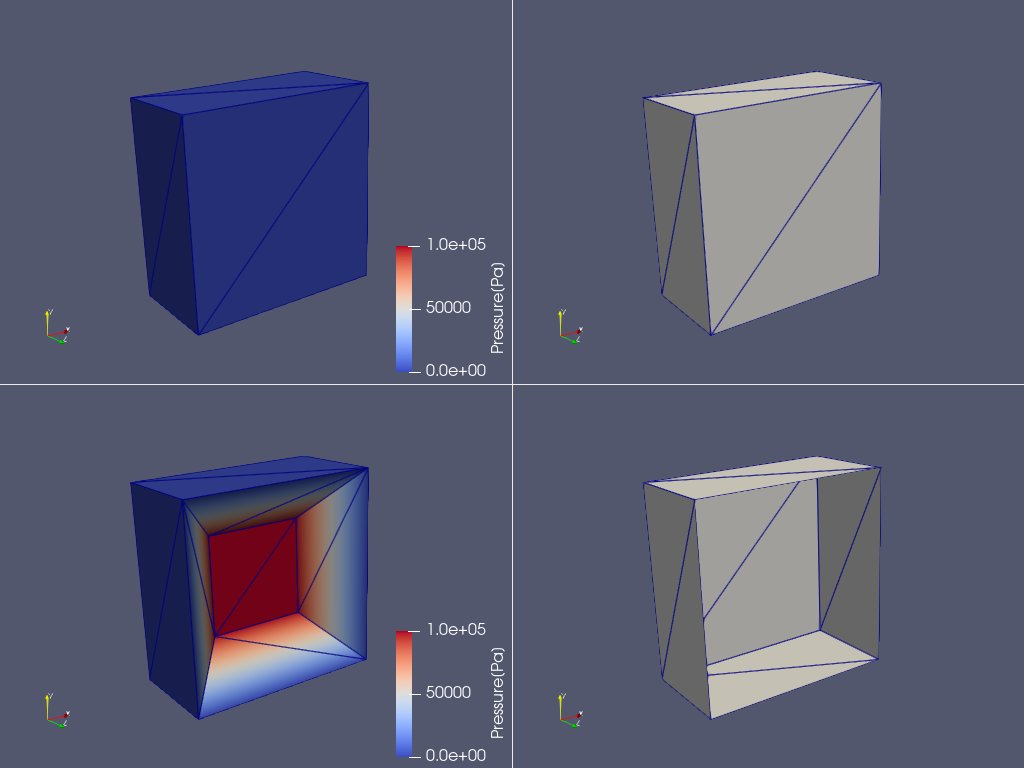


The left column of the above picture shows a compliant-hydroelastic box,
and the right column shows a rigid-hydroelastic box.
The top-left picture shows the tetrahedral mesh with pressure field viewed from outside
with zero pressure on the boundary surface,
and the bottom-left picture hides some tetrahedra to show pressure distribution inside the box.
The top-right picture shows the triangle mesh of the rigid-hydroelastic box,
and the bottom-right picture hides some triangles to show the empty space inside the rigid-hydroelastic box.

## Contact patches

As shown below, the contact patch between two compliant-hydroelastic geometries is internal to both solids,
defined as the surface where the two pressure fields are equal. In the following picture, a compliant-hydroelastic cylinder contacts a compliant-hydroelastic ball. Their contact patch is a blending surface between the cylindrical surface and the spherical surface. The shading on the contact patch shows pressure distribution varying from black for zero pressure to red for high pressure.

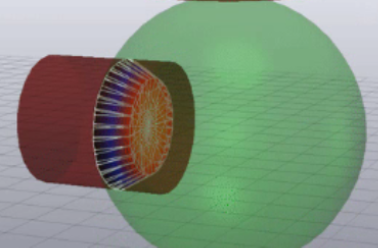

Alternatively, the contact patch between a compliant-hydroelastic geometry and
a rigid-hydroelastic geometry is on the surface of the rigid-hydroelastic geometry,
as shown in the following picture.
Two hydroelastic-compliant ellipsoidal bubble fingers make contact with
a rigid-hydroelastic handle of the spatula.
Their contact surfaces are on the surface of the cylindrical handle.

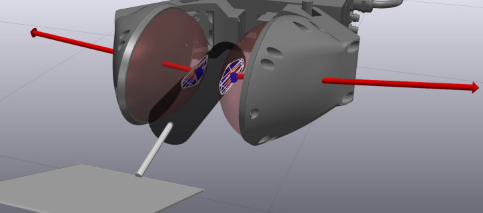

## Contact mode between compliant-hydroelastic geometries and rigid-hydroelastic geometries

In general, consider using compliant-hydroelastic geometries because
the object's stiffness can be specified through its hydroelastic modulus
to be as compliant as rubber or as stiff as steel.
Compliant-hydroelastic geometries need tetrahedral meshes.
Drake can automatically generate tetrahedral meshes of compliant-hydroelastic geometries for
built-in shapes such as spheres, ellipsoids, cylinders, capsules, boxes and
for solids with a convex surface mesh.
For non-convex objects, users must provide tetrahedral meshes in VTK files
to use them as compliant-hydroelastic geometries.

Compliant-hydroelastic objects interact well with either compliant-hydroelastic objects
or with rigid-hydroelastic objects.

Alternatively, an important use for rigid-hydroelastic geometry is for an object
with a non-convex surface mesh (e.g., .obj file) whose associated tetrahedral volume mesh
is not readily available.
Currently, a rigid-hydroelastic geometry can only interact with compliant-hydroelastic objects.
If it interacts with another rigid-hydroelastic object, the simulator reverts to point contact.
The table below elaborates these and other cases.


|                                     | rigid-hydroelastic geometry   | compliant-hydroelastic geometry |
|:------------------------------------|:------------------------------|:--------------------------------|
| **rigid-hydroelastic geometry**     | point contact                 | hydroelastic contact            |
| **compliant-hydroelastic geometry** | hydroelastic contact          | hydroelastic contact            |
| **non-hydroelastic geometry**       | point contact                 | point contact                   |



## Outline

This tutorial will show you how to:

1. Define SDFormat string for a compliant-hydroelastic box.

    * Define a visual geometry.
    * Define a collision geometry with hydroelastic properties.
    * Define mass and inertia properties.


2. Define SDFormat string for a rigid-hydroelastic box.

3. Create Diagram of MultibodyPlant using the two boxes.

4. Visualize the simulation.

5. Create a LeafSystem to numerically report contact results at the end of simulation.

6. Add ContactVisualizer to visualize contact results.

## Start MeshCat

See the section [Viewing models](./authoring_multibody_simulation.ipynb#Viewing-models) in the tutorial [Authoring a Multibody Simulation](./authoring_multibody_simulation.ipynb) for introduction to MeshCat.

In [ ]:
from pydrake.geometry import StartMeshcat

# Start the visualizer. The cell will output an HTTP link after the execution.
# Click the link and a MeshCat tab should appear in your browser.
meshcat = StartMeshcat()

## Create compliant-hydroelastic box

*Make sure you have the MeshCat tab opened in your browser;
the link is shown immediately above.*

We will create and visualize a compliant-hydroelastic box with SDFormat string.

We will use `ModelVisualizer` to verify the SDFormat description.
It will tell MeshCat to show the box.

### Visual geometry

First we create a visual geometry of a box of size 10cm x 20cm x 40cm.
Observe in MeshCat the X(red), Y(green), and Z(blue) axes.
The `<size>0.10 0.20 0.40</size>` specifies the dimensions of the box in meters.
The `<diffuse>` tag specifies the RGB and alpha values between 0 and 1.

In [ ]:
from pydrake.visualization import ModelVisualizer

visual_box_sdf = """<?xml version="1.0"?>
<sdf version="1.7">
  <model name="CompliantBox">
    <pose>0 0 0 0 0 0</pose>
    <link name="compliant_box">
      <visual name="visual">
        <geometry>
          <box>
            <size>0.10 0.20 0.40</size>
          </box>
        </geometry>
        <material>
          <diffuse>1.0 1.0 1.0 0.5</diffuse>
        </material>
      </visual>
    </link>
  </model>
</sdf>
"""

# Visualize the SDFormat string you just defined.
visualizer = ModelVisualizer(meshcat=meshcat, visualize_frames=True)
visualizer.parser().AddModelsFromString(visual_box_sdf, "sdf")
visualizer.Run(loop_once=True)

### Collision geometry with hydroelastic properties

We will add the `<collision>` block with hydroelastic properties.
Without `<collision>`, our object cannot make contact in the simulation.

We specify the same collision geometry (box of size 10x20x40 centimeters) as
the visual geometry.

Drake also uses the term proximity for collision.
This is the `<drake:proximity_properties>` block that control hydroelastic contacts:

        <drake:proximity_properties>
          <drake:compliant_hydroelastic/>
          <drake:hydroelastic_modulus>1e7</drake:hydroelastic_modulus>
          <drake:mu_dynamic>0.5</drake:mu_dynamic>
          <drake:hunt_crossley_dissipation>1.25</drake:hunt_crossley_dissipation>
        </drake:proximity_properties>

Use `<drake:compliant_hydroelastic/>` to specify a compliant-hydroelastic object.

We set `<drake:hydroelastic_modulus>` to 1e7 Pascals.
It is comparable to high-density polyethylene (HDPE) with 1 GPa Young's modulus.
Hydroelastic modulus is not a physical property but rather a numerical parameter to
tune our contact model.
As a rule of thumb, set hydroelastic modulus to about 1/100 of Young's modulus. 

We set `<drake:mu_dynamic>` (unitless) to 0.5 for the friction coefficient.

We set `<drake:hunt_crossley_dissipation>` to 1.25 seconds/meter as
the dissipation constant for TAMSI contact solver.
In the future, SAP will support Hunt & Crossley dissipation model too.
See issue
[19320](https://github.com/RobotLocomotion/drake/issues/19320).
Intuitively the bouncing speed (speed when the box bounces back) is bounded by
the inverse of Hunt & Crossley dissipation constant.
Here we set it to 1.25 s/m, so the bouncing speed is at most 0.8 m/s.
See
[Contact Modeling](https://drake.mit.edu/doxygen_cxx/classdrake_1_1multibody_1_1_multibody_plant.html#mbp_contact_modeling)
in
[MultibodyPlant](https://drake.mit.edu/doxygen_cxx/classdrake_1_1multibody_1_1_multibody_plant.html)
documentation for more details.

In [ ]:
from pydrake.visualization import ModelVisualizer

collision_box_sdf = """<?xml version="1.0"?>
<sdf version="1.7">
  <model name="CompliantBox">
    <pose>0 0 0 0 0 0</pose>
    <link name="compliant_box">
      <collision name="collision">
        <geometry>
          <box>
            <size>0.10 0.20 0.40</size>
          </box>
        </geometry>
        <drake:proximity_properties>
          <drake:compliant_hydroelastic/>
          <drake:hydroelastic_modulus>1e7</drake:hydroelastic_modulus>
          <drake:mu_dynamic>0.5</drake:mu_dynamic>
          <drake:hunt_crossley_dissipation>1.25</drake:hunt_crossley_dissipation>
        </drake:proximity_properties>
      </collision>
      <visual name="visual">
        <geometry>
          <box>
            <size>0.10 0.20 0.40</size>
          </box>
        </geometry>
        <material>
          <diffuse>1.0 1.0 1.0 0.5</diffuse>
        </material>
      </visual>
    </link>
  </model>
</sdf>
"""

# Visualize the SDFormat string you just defined.
visualizer = ModelVisualizer(meshcat=meshcat, visualize_frames=True)
visualizer.parser().AddModelsFromString(collision_box_sdf, "sdf")
visualizer.Run(loop_once=True)

### Inertial properties

In order to simulate dynamics, we will add `<mass>` of 1kg and `<inertia>` matrix.

The `<inertia>` of the box follows this formula:

    Ixx = m(s.y² + s.z²)/12
    Iyy = m(s.x² + s.z²)/12
    Izz = m(s.x² + s.y²)/12
    
where s.x, s.y, and s.z are the dimensions of the box.
    
In practice, we can use `SpatialInertia.SolidBoxWithMass()` as
shown below and copy the numbers into SDFormat string afterwards.
See documentation of
[SpatialInertia](https://drake.mit.edu/doxygen_cxx/classdrake_1_1multibody_1_1_spatial_inertia.html)
for description of the 6x6 matrix.

In [ ]:
from pydrake.multibody.tree import SpatialInertia

spatial_inertia = SpatialInertia.SolidBoxWithMass(
          mass=1, lx=0.1, ly=0.2, lz=0.4)
mass = spatial_inertia.get_mass()
center_of_mass = spatial_inertia.get_com()
matrix6 = spatial_inertia.CopyToFullMatrix6()

print(f"mass = {mass}\n")
print(f"p_PScm = center of mass = {center_of_mass}\n")
print(f"I_SP = rotational inertia = \n{matrix6[:3, :3]}\n")

The function `compliant_box()` below returns SDFormat description of
the compliant-hydroelastic box given `hydroelastic_modulus`.
We will use this function later when we experiment with
different values of hydroelastic modulus.
The numbers in `<inertial>` block are copied from the result of
exercising the above code with SpatialInertia.

Notice that the parameter `hydroelastic_modulus` is
a character string `'1e7'` (it is enclosed by single quote `'`)
not a floating-point number `1e7`,
so that the SDFormat description does not lose precision due to formatting.

In [ ]:
from pydrake.visualization import ModelVisualizer

# Define a compliant-hydroelastic box from
# a given hydroelastic modulus.
def compliant_box(hydroelastic_modulus='1e7'):
    return f"""<?xml version="1.0"?>
    <sdf version="1.7">
      <model name="CompliantBox">
        <pose>0 0 0 0 0 0</pose>
        <link name="compliant_box">
          <inertial>
            <mass>1.0</mass>
            <inertia>
              <ixx>0.016666</ixx> <ixy>0.0</ixy> <ixz>0.0</ixz>
              <iyy>0.014166</iyy> <iyz>0.0</iyz>
              <izz>0.004166</izz>
            </inertia>
          </inertial>
          <collision name="collision">
            <geometry>
              <box>
                <size>0.10 0.20 0.40</size>
              </box>
            </geometry>
            <drake:proximity_properties>
              <drake:compliant_hydroelastic/>
              <drake:hydroelastic_modulus>{hydroelastic_modulus}</drake:hydroelastic_modulus>
              <drake:mu_dynamic>0.5</drake:mu_dynamic>
              <drake:hunt_crossley_dissipation>1.25</drake:hunt_crossley_dissipation>
              <drake:relaxation_time>0.1</drake:relaxation_time>
            </drake:proximity_properties>
          </collision>
          <visual name="visual">
            <geometry>
              <box>
                <size>0.10 0.20 0.40</size>
              </box>
            </geometry>
            <material>
              <diffuse>1.0 1.0 1.0 0.5</diffuse>
            </material>
          </visual>
        </link>
      </model>
    </sdf>
    """

compliant_box_sdf = compliant_box()
print(compliant_box_sdf)

# Visualize the SDFormat string you just defined.
visualizer = ModelVisualizer(meshcat=meshcat, visualize_frames=True)
visualizer.parser().AddModelsFromString(compliant_box_sdf, "sdf")
visualizer.Run(loop_once=True)

## Create rigid-hydroelastic box

The following SDFormat string specifies a rigid-hydroelastic box.
It is similar to the compliant-hydroelastic box.

Both the `<visual>` and `<collision>` geometries are boxes of size 60cm x 1m x 5cm.
Observe in MeshCat the X(red), Y(green), and Z(blue) axes.

Use the tag `<drake:rigid_hydroelastic/>` to specify a rigid-hydroelastic geometry.
It does not use `<drake:hydroelastic_modulus>`.
Intuitively it has infinite hydroelastic modulus.

This rigid-hydroelastic box uses the same friction coefficient and dissipation constants as
the previous compliant-hydroelastic box.

We do not specify `<mass>` and `<inertia>` of the rigid box because,
in the next section when we set up `Diagram`,
we will fix the rigid box to the world frame.
It will not move.
    
The `<frame name="top_surface">` is a frame at the top of the box with the tag:

    <pose relative_to="rigid_box_link">0 0 0.025 0 0 0</pose>

It is at 2.5cm (half of the box's height) above the center of the box.
In the next section, we will create a scene that places the `top_surface` frame at the world's origin.

In [ ]:
from pydrake.visualization import ModelVisualizer

# Create a rigid-hydroelastic table top
rigid_box_sdf = """<?xml version="1.0"?>
<sdf version="1.7">
  <model name="RigidBox">
    <link name="rigid_box_link">
      <visual name="visual">
        <pose>0 0 0 0 0 0</pose>
        <geometry>
          <box>
            <size>0.6 1.0 0.05</size>
          </box>
        </geometry>
        <material>
         <diffuse>0.9 0.8 0.7 0.5</diffuse>
        </material>
      </visual>
      <collision name="collision">
        <pose>0 0 0 0 0 0</pose>
        <geometry>
          <box>
            <size>0.6 1.0 0.05</size>
          </box>
        </geometry>
        <drake:proximity_properties>
          <drake:rigid_hydroelastic/>
          <drake:mu_dynamic>0.5</drake:mu_dynamic>
          <drake:hunt_crossley_dissipation>1.25</drake:hunt_crossley_dissipation>
          <drake:relaxation_time>0.1</drake:relaxation_time>
        </drake:proximity_properties>
      </collision>
    </link>
    <frame name="top_surface">
      <pose relative_to="rigid_box_link">0 0 0.025 0 0 0</pose>
    </frame>
  </model>
</sdf>

"""

# Visualize the SDFormat string you just defined.
visualizer = ModelVisualizer(meshcat=meshcat, visualize_frames=True)
visualizer.parser().AddModelsFromString(rigid_box_sdf, "sdf")
visualizer.Run(loop_once=True)

## Create Diagram of the scene

The function `add_scene()` below creates a scene using the two boxes that we created.

It uses `DiagramBuilder` to create `MultibodyPlant` and `SceneGraph`.
It uses `Parser` to add the two SDFormat strings of the two boxes into `Diagram` of the scene.

It fixes the rigid box's top surface to the world frame by calling `WeldFrames()`.

It places the compliant box 1 meter above the rigid box.

After this step, the next section will add visualization to `DiagramBuilder`.

In [ ]:
from pydrake.math import RigidTransform
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlant, MultibodyPlantConfig
from pydrake.systems.framework import DiagramBuilder

def clear_meshcat():
    # Clear MeshCat window from the previous blocks.
    meshcat.Delete()
    meshcat.DeleteAddedControls()

def add_scene(time_step=1e-3, solver="tamsi"):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlant(
        MultibodyPlantConfig(
            time_step=time_step,
            discrete_contact_solver=solver),
        builder)
    parser = Parser(plant)

    # Load the table top and the box we created.
    parser.AddModelsFromString(compliant_box_sdf, "sdf")
    parser.AddModelsFromString(rigid_box_sdf, "sdf")

    # Weld the rigid box to the world so that it's fixed during simulation.
    # The top surface passes the world's origin.
    plant.WeldFrames(plant.world_frame(), 
                     plant.GetFrameByName("top_surface"))

    # Finalize the plant after loading the scene.
    plant.Finalize()

    # Set how high the center of the compliant box is from the world's origin. 
    # W = the world's frame
    # C = frame at the center of the compliant box
    X_WC = RigidTransform(p=[0, 0, 1])
    plant.SetDefaultFreeBodyPose(plant.GetBodyByName("compliant_box"), X_WC)

    return builder, plant

## Set up visualization of the simulation

The function `add_scene()` above does not have visualization,
so we will do it in the function `add_viz()` below.

It uses `DiagramBuilder` from `add_scene()`.
The `meshcat` interface represents the same MeshCat window that we have been using.

We set the `publish_period` to 1/256, so we can publish 256 frames per simulated second.
In this example, we publish quite frequently, so later we can appreciate dynamics better.
See documentation of 
[VisualizationConfig](https://drake.mit.edu/doxygen_cxx/structdrake_1_1visualization_1_1_visualization_config.html)
for more details.

At this step we set `publish_contacts` to `False`,
we will set up contact visualization near the end of this tutorial.

We test the creation of `Diagram` by simulating for 0 second.
It shows the compliant box 1 meter above the rigid box.
You might have to zoom out to see both boxes at the same time.

In [ ]:
from pydrake.visualization import ApplyVisualizationConfig, VisualizationConfig

def add_viz(builder, plant):
    ApplyVisualizationConfig(
        config=VisualizationConfig(
                   publish_period = 1 / 256.0,
                   publish_contacts = False),
        builder=builder, meshcat=meshcat)
    
    return builder, plant


from pydrake.systems.analysis import Simulator

# Test creation of the diagram by simulating for 0 second.
# For now, use only the DiagramBuilder from the first return value and
# ignore the other return value. We will use it later.
clear_meshcat()
builder, plant = add_scene()
add_viz(builder, plant)
simulator = Simulator(builder.Build())
simulator.Initialize()
simulator.AdvanceTo(0)

## Run the simulation

We define the function `run_simulation()` below.
It builds `Diagram` using `DiagramBuilder` from the previous step.
It passes `Diagram` to `Simulator`.
It also records simulation result into `meshcat` for playback later.
You should see the compliant box drops down to make contact with the rigid box.

In [ ]:
from pydrake.systems.analysis import Simulator

def run_simulation(sim_time, time_step=1e-3, solver="tamsi"):
    clear_meshcat()
    
    builder, plant = add_scene(time_step, solver)
    add_viz(builder, plant)
    
    diagram = builder.Build()
    
    simulator = Simulator(diagram)
    simulator.Initialize()
    simulator.set_target_realtime_rate(1.)
    
    meshcat.StartRecording(frames_per_second=256.0)
    simulator.AdvanceTo(sim_time)
    meshcat.StopRecording()


run_simulation(sim_time=6)

## Playback recording of the simulation

The following command `meshcat.PublishRecording()` will create a playback in MeshCat tab.
It will enable `Animations` panel in MeshCat tab.

In [ ]:
meshcat.PublishRecording()

In MeshCat window, click on `Open Controls` if you haven't done it.
You should see `Animations` panel that look like this picture:

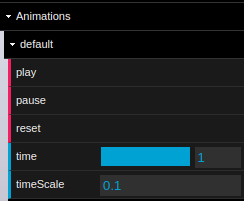


Use the **play** button to replay the animation.

Adjust **timeScale** to control animation speed.
Set it to 0.1 for slower playback to appreciate dynamics.

Use **pause** to stop animation in the middle,
and use **reset** to move the animation back to time 0.


During the playback, you should see the compliant box drops down to
make contact with the rigid box and bounces back at about 0.4s simulated time.
The gravity will pull it down to make contact again.
It will rock back and forth for a few seconds and
reach steady state after about 6 seconds simulated time.

You can type **time** in the `Animations` panel to
go to a particular snapshot in the animation.

One advantage of playback is that you can watch animation at
real-time rate with `timeScale=1` regardless of how fast
or how slow the simulation is.
The wall-clock time of the simulation has no consequence to
the simulated time that we see in the playback.

# Report contact results numerically

We will show you how to report contact results.
We will create a simple system to read contact results from `MultibodyPlant` and
print them at the end of simulation.

## Use a simple system to publish contact results

If you are not familiar with creating a leaf system,
please see the tutorial [Authoring Leaf Systems](./authoring_leaf_systems.ipynb).

We will define a leaf system called `ContactReporter` below.
It has an input port that takes
[ContactResults.](https://drake.mit.edu/doxygen_cxx/classdrake_1_1multibody_1_1_contact_results.html)
When there is a forced publish event,
it will print the contact results from its input port.
See `Publish(self, context)` in the code below. 

Contact results are available from an output port of
[MultibodyPlant](https://drake.mit.edu/doxygen_cxx/classdrake_1_1multibody_1_1_multibody_plant.html)
by calling get_contact_results_output_port().
See documentation of
[MultibodyPlant's input and output ports](https://drake.mit.edu/doxygen_cxx/classdrake_1_1multibody_1_1_multibody_plant.html#mbp_input_and_output_ports)
for the list of available ports.
In the function `add_contact_report()` below,
first we add `ContactReporter` to the diagram builder from the previous section.
Then, we connect the contact results output port of MultibodyPlant to
the input port of our `ContactReporter`. 

The simulation in our example has only one cotact patch between two geometries, but
the code below can report all contact patches from all pairs of geometries from hydroelastics.
However, it does not report `point_pair_contact_info()` in ContactResults.

See documentation of
[ContactResults,](https://drake.mit.edu/doxygen_cxx/classdrake_1_1multibody_1_1_contact_results.html)
[HydroelasticContactInfo,](https://drake.mit.edu/doxygen_cxx/classdrake_1_1multibody_1_1_hydroelastic_contact_info.html)
and
[ContactSurface](https://drake.mit.edu/doxygen_cxx/classdrake_1_1geometry_1_1_contact_surface.html)
for more details.

In `__init__()` of `ContactReporter`, we declare forced publish event,
so it will report contacts only when users call `ForcedPublish()`
(see `run_simulation_with_contact_report()` in the next section).
You can also declare periodic publish events to report contact at the frequency that you specify.
See
[Declare periodic events](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_leaf_system.html#declare_periodic_events)
in documentation of
[LeafSystem.](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_leaf_system.html)

In [ ]:
from pydrake.common.value import AbstractValue
from pydrake.multibody.plant import ContactResults
from pydrake.systems.framework import LeafSystem

class ContactReporter(LeafSystem):
    def __init__(self):
        super().__init__()  # Don't forget to initialize the base class.
        self.DeclareAbstractInputPort(
            name="contact_results",
            model_value=AbstractValue.Make(
                # Input port will take ContactResults from MultibodyPlant
                ContactResults()))
        # Calling `ForcedPublish()` will trigger the callback.
        self.DeclareForcedPublishEvent(self.Publish)
        
    def Publish(self, context):
        print()
        print(f"ContactReporter::Publish() called at time={context.get_time()}")
        contact_results = self.get_input_port().Eval(context)
        
        num_hydroelastic_contacts = contact_results.num_hydroelastic_contacts()
        print(f"num_hydroelastic_contacts() = {num_hydroelastic_contacts}")
        
        for c in range(num_hydroelastic_contacts):
            print()
            print(f"hydroelastic_contact_info({c}): {c}-th hydroelastic contact patch")
            hydroelastic_contact_info = contact_results.hydroelastic_contact_info(c)
            
            spatial_force = hydroelastic_contact_info.F_Ac_W()
            print(f"F_Ac_W(): spatial force (on body A, at centroid of contact surface, in World frame) = \\")
            print(f"{spatial_force}")
                        
            print(f"contact_surface()")
            contact_surface = hydroelastic_contact_info.contact_surface()
            num_faces = contact_surface.num_faces()
            total_area = contact_surface.total_area()
            centroid = contact_surface.centroid()
            print(f"total_area(): area of contact surface in m^2 = {total_area}")
            print(f"num_faces(): number of polygons or triangles = {num_faces}")
            print(f"centroid(): centroid (in World frame) = {centroid}")        
        
        print()

def add_contact_report(builder, plant):   
    contact_reporter = builder.AddSystem(ContactReporter())    
    builder.Connect(plant.get_contact_results_output_port(),
                    contact_reporter.get_input_port(0))
        
    return builder, plant

## Run simulation and report contact results

As shown below, the function `run_simulation_with_contact_report()` 
calls `ForcedPublish()` after the simulation has finished.

The end of the code block calls `run_simulation_with_contact_report()`
with `sim_time=0`.
At time 0, the compliant box starts far above the rigid box.
The printout will simply say there is no contact yet.
It should look like this:

```
ContactReporter::Publish() called at time=0.0
num_hydroelastic_contacts() = 0
```

In [ ]:
from pydrake.systems.analysis import Simulator

def run_simulation_with_contact_report(sim_time, time_step=1e-3, solver="tamsi"):
    clear_meshcat()
    
    builder, plant = add_scene(time_step, solver)
    add_viz(builder, plant)
    add_contact_report(builder, plant)
    
    diagram = builder.Build()
    
    simulator = Simulator(diagram)
    simulator.Initialize()
    simulator.set_target_realtime_rate(1.)
    
    meshcat.StartRecording(frames_per_second=256.0)
    simulator.AdvanceTo(sim_time)
    meshcat.StopRecording()

    # Forced publish after the simulation has finished.
    diagram.ForcedPublish(simulator.get_context())
    

run_simulation_with_contact_report(sim_time=0)
meshcat.PublishRecording()

We will run it again for 1 second simulated time.
Since we will call `meshcat.PublishRecording()` on the second line,
it will look like we drop the compliant box twice.
The first animation is directly from the simulation,
and the repeated animation is from the playback.
You can zoom-in and slow down the playback in MeshCat tab
(set `timeScale` to 0.1) to carefully observe dynamics.

After running the code below, you should see
the spatial force `F_Ac_W` consisting of the torque `tau`
and the force `f`.
The force `f=[-1.4698008107796352, 1.2910859070622505, 9.190361581929913]`,
expressed in World frame, has the Z component about 9.19 newtons.
It is less than 9.81 newtons,
which is the gravity force acting on the compliant box with mass 1kg.
This is because the compliant box is still rocking back and forth
at the 1-second simulated time.

The contact results are reported in World frame.

In [ ]:
run_simulation_with_contact_report(sim_time=1)
meshcat.PublishRecording()

In the next code block,
you will run the simulation for 6 seconds to steady state,
and you should see `f.Z()` around 9.81 newtons equal to the gravity force:

>   f=[0.0029448765571535667, 0.001046731084481263, 9.809999983708687]

In [ ]:
run_simulation_with_contact_report(sim_time=6)
meshcat.PublishRecording()

# Visualize contact results

To visualize contact results, we will add `ContactVisualizer` to `Diagram` of the previous section.

The following function `add_contact_viz()` adds `ContactVisualizer` to `DiagramBuilder` using `MultibodyPlant` and `meshcat`.

With `newtons_per_meter= 2e1`, it will draw a red arrow of length 1 meter for
each force of 20 newtons.
With `newtons_meters_per_meter= 1e-1`, it will draw a blue arrow of length 1 meter for
each torque of 0.1 newton\*meters. The next section will run the simulation.

In [ ]:
from pydrake.multibody.meshcat import ContactVisualizer, ContactVisualizerParams


def add_contact_viz(builder, plant):
    contact_viz = ContactVisualizer.AddToBuilder(
        builder, plant, meshcat,
        ContactVisualizerParams(
            publish_period= 1.0 / 256.0,
            newtons_per_meter= 2e1,
            newton_meters_per_meter= 1e-1))

    return builder, plant

## Run simulation with contact visualization

The following code will run the simulation.
In MeshCat, the red arrow represents the force `f`,
and the blue arrow represents the torque `tau`.
You should see the contact patch moving around together with the force and torque vectors.
At the end of simulation, it will also report contact result numerically.

Notice that the code below does not publish the recording yet.
The next section will publish the recording for playback.

In [ ]:
from pydrake.systems.analysis import Simulator

def run_simulation_with_contact_report_and_viz(sim_time, time_step=1e-3, solver="tamsi"):
    clear_meshcat()
    
    builder, plant = add_scene(time_step, solver)
    add_viz(builder, plant)
    add_contact_report(builder, plant)
    add_contact_viz(builder, plant)
    
    diagram = builder.Build()
    
    simulator = Simulator(diagram)
    simulator.Initialize()
    simulator.set_target_realtime_rate(1.0)
    
    meshcat.StartRecording(frames_per_second=256.0)
    simulator.AdvanceTo(sim_time)
    meshcat.StopRecording()

    # Numerically report contact results at the end of simulation.
    diagram.ForcedPublish(simulator.get_context())

    
run_simulation_with_contact_report_and_viz(sim_time=6)

## Playback recording to appreciate dynamics

After running the code below, playback with `timeScale` = 0.1 or 0.01 to appreciate the contact dynamics.
You should see the force and torque vectors oscillate synchronously with the rocking compliant box.

Currently playing back the simulation will show contact force and moment;
however, it does not show contact patch appropriately,
which could be confusing.
The code below deletes the contact patch from the recording before publishing to MeshCat.
Issue
[19142](https://github.com/RobotLocomotion/drake/issues/19142)
explains the problem in more details.

In [ ]:
# In the current version, we can playback contact forces and torques;
# however, contact surfaces are not recorded properly.
# For now, we delete contact surfaces to prevent confusion.
# See issue https://github.com/RobotLocomotion/drake/issues/19142
meshcat.Delete("/drake/contact_forces/hydroelastic/compliant_box+rigid_box_link/contact_surface");

meshcat.PublishRecording()

# Optional exercises

The following sections are optional.
It strengthens your understanding of our code and its capability,
but you do not need to learn it in order to use hydroelastic contact.

## High impact at first contact
At 0.405 second, the compliant box makes a high impact on the rigid box.
Remove `#` below and run the code.
How large is the contact force at impact?
You should see almost 380 newtons!

In [ ]:
# run_simulation_with_contact_report_and_viz(sim_time=0.405)
# meshcat.Delete("/drake/contact_forces/hydroelastic/compliant_box+rigid_box_link/contact_surface");
# meshcat.PublishRecording()

## Effects of low hydroelastic modulus

The code below change the value of hydroelastic modulus in `compliant_box_sdf` to the `new_hydroelastic_modulus`. Notice that we use the single quoted `'` to enclose the number for `new_hydroelastic_modulus`, so it is treated as a character string.

Set `new_hydroelastic_modulus` to unphysically low value like 1e1 Pascals,
and you should see the compliant box drops down and passes through the rigid box.
This is because the low hydroelastic modulus cannot make enough
contact force to match gravity force.
Most materials has Young's modulus in the range of 1e7 Pa (rubber) to 1e12 Pa (carbon nanotube),
so their hydroelastic modulus should be in the range of 1e5 Pa (rubber) to
1e10 Pa (carbon nanotube).

Remove `#` in the code below and run it.

Playback slowly with timeScale 0.1 in MeshCat,
and you should see very short red arrows of contact forces.

In [ ]:
# new_hydroelastic_modulus = '1e1'
# compliant_box_sdf = compliant_box(hydroelastic_modulus = new_hydroelastic_modulus)
#
# run_simulation_with_contact_report_and_viz(sim_time=2)
# meshcat.Delete("/drake/contact_forces/hydroelastic/compliant_box+rigid_box_link/contact_surface");
# meshcat.PublishRecording()

## Effects of high hydroelastic modulus

Similarly, the code below sets `new_hydroelastic_modulus` to an unusual high value of 1e15 Pascals.
You should see the compliant box bounces violently and falls off the rigid box.
Remove `#` in the code below and run it.

In [ ]:
# new_hydroelastic_modulus = '1e15'
# compliant_box_sdf = compliant_box(hydroelastic_modulus = new_hydroelastic_modulus)
# 
# run_simulation_with_contact_report_and_viz(sim_time=2)
# meshcat.Delete("/drake/contact_forces/hydroelastic/compliant_box+rigid_box_link/contact_surface");
# meshcat.PublishRecording()

## Further reading

* [Hydroelastic Contact User Guide](https://drake.mit.edu/doxygen_cxx/group__hydroelastic__user__guide.html)

* Elandt, R., Drumwright, E., Sherman, M., & Ruina, A. (2019, November). 
  A pressure field model for fast, robust approximation of net contact force and
  moment between nominally rigid objects.
  In 2019 IEEE/RSJ International Conference on Intelligent Robots and 
  Systems(IROS) (pp. 8238-8245). IEEE.
  [link](https://arxiv.org/abs/1904.11433)

* Masterjohn, J., Guoy, D., Shepherd, J., & Castro, A. (2022).
  Velocity Level Approximation of Pressure Field Contact Patches.
  IEEE Robotics and Automation Letters 7, no. 4 (2022): 11593-11600.
  [link](https://arxiv.org/abs/2110.04157v2)
  

* Elandt, R. (2022, December). Pressure Field Contact. Dissertation. Cornell University.
  [link](https://ecommons.cornell.edu/handle/1813/112919)
